In [8]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import backtrader as bt

In [9]:
# Binance Vision klines format: https://data.binance.vision/
# Columns: open_time, open, high, low, close, volume, close_time, quote_asset_volume,
#          number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume, ignore
COLUMNS = [
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_asset_volume', 'number_of_trades',
    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
]

def load_symbol_data(symbol, interval, data_dir='Data'):
    """
    Load all klines data for a symbol from the Data directory.
    Files are named: {symbol}-{interval}-{YYYY-MM-DD}.csv (e.g. ETHUSDT-15m-2025-12-01.csv)
    """
    pattern = f"{data_dir}/{symbol}-{interval}-*.csv"
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No data found for {symbol} {interval} in {data_dir}")
    dfs = [pd.read_csv(f, names=COLUMNS) for f in files]
    df = pd.concat(dfs, ignore_index=True).sort_values('open_time').reset_index(drop=True)
    return df

df = load_symbol_data('ETHUSDT', '15m')
df['datetime'] = pd.to_datetime(df['open_time'], unit='us')
df['returns'] = df['close'].pct_change()
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,datetime,returns
0,1764547200000000,2991.25,2999.47,2906.02,2917.00,29621.7933,1764548099999999,8.726891e+07,240763,12368.8640,3.639587e+07,0,2025-12-01 00:00:00,NaN
1,1764548100000000,2917.00,2924.78,2885.00,2893.54,18521.1831,1764548999999999,5.373785e+07,198733,8046.7779,2.335303e+07,0,2025-12-01 00:15:00,-0.008043
2,1764549000000000,2893.53,2896.50,2862.01,2864.83,22297.4500,1764549899999999,6.407964e+07,216368,10671.8002,3.066050e+07,0,2025-12-01 00:30:00,-0.009922
3,1764549900000000,2864.83,2865.50,2830.63,2836.40,29730.0647,1764550799999999,8.470877e+07,169091,14505.5339,4.133694e+07,0,2025-12-01 00:45:00,-0.009924
4,1764550800000000,2836.40,2860.00,2833.65,2848.80,13114.3766,1764551699999999,3.738288e+07,141441,6409.6167,1.827185e+07,0,2025-12-01 01:00:00,0.004372


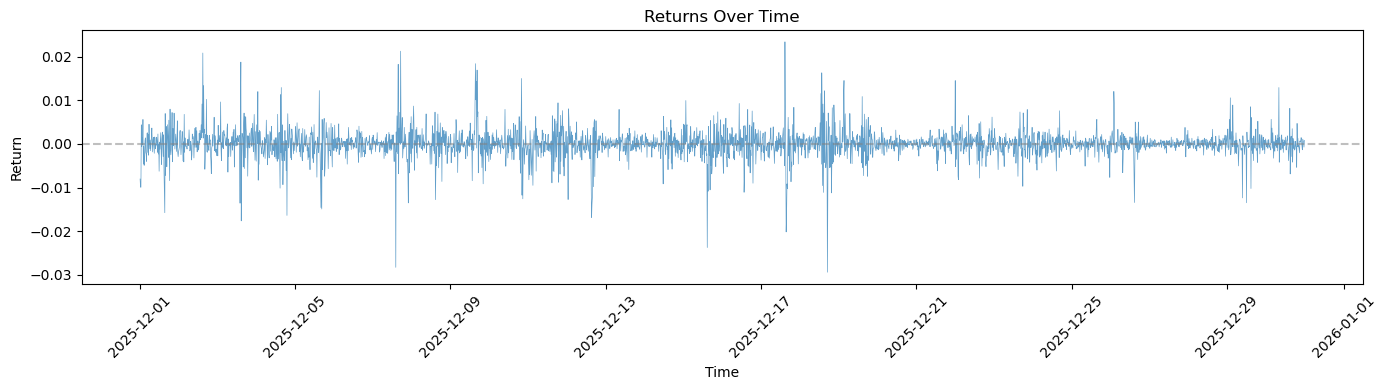

In [10]:
# Returns over time
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df['datetime'], df['returns'], alpha=0.7, linewidth=0.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Time')
ax.set_ylabel('Return')
ax.set_title('Returns Over Time')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

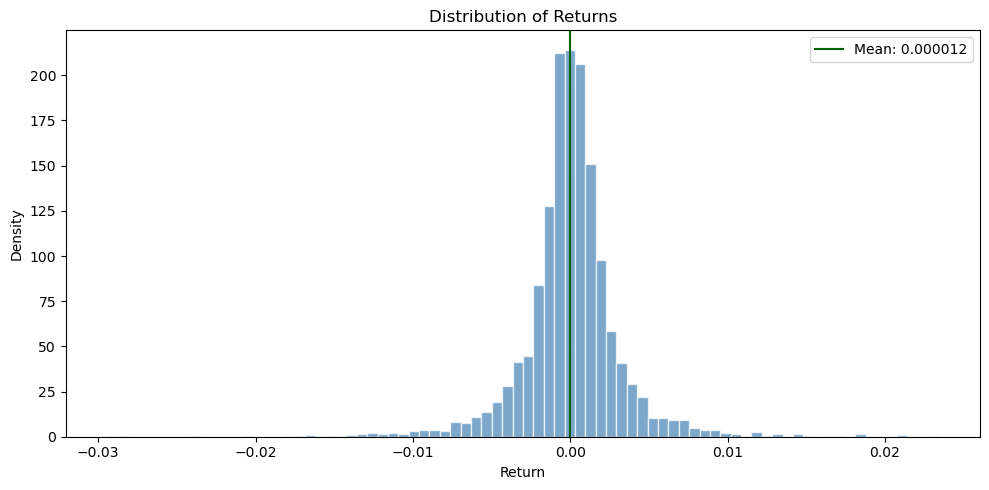

In [11]:
# Distribution of returns
returns = df['returns'].dropna()
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(returns, bins=80, density=True, alpha=0.7, edgecolor='white', color='steelblue')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.8)
ax.axvline(x=returns.mean(), color='darkgreen', linestyle='-', label=f'Mean: {returns.mean():.6f}')
ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.set_title('Distribution of Returns')
ax.legend()
plt.tight_layout()
plt.show()

## Backtest with Simple MA

Starting Portfolio Value: 10000.0
Ending Portfolio Value: 9080.006703556879


<IPython.core.display.Javascript object>

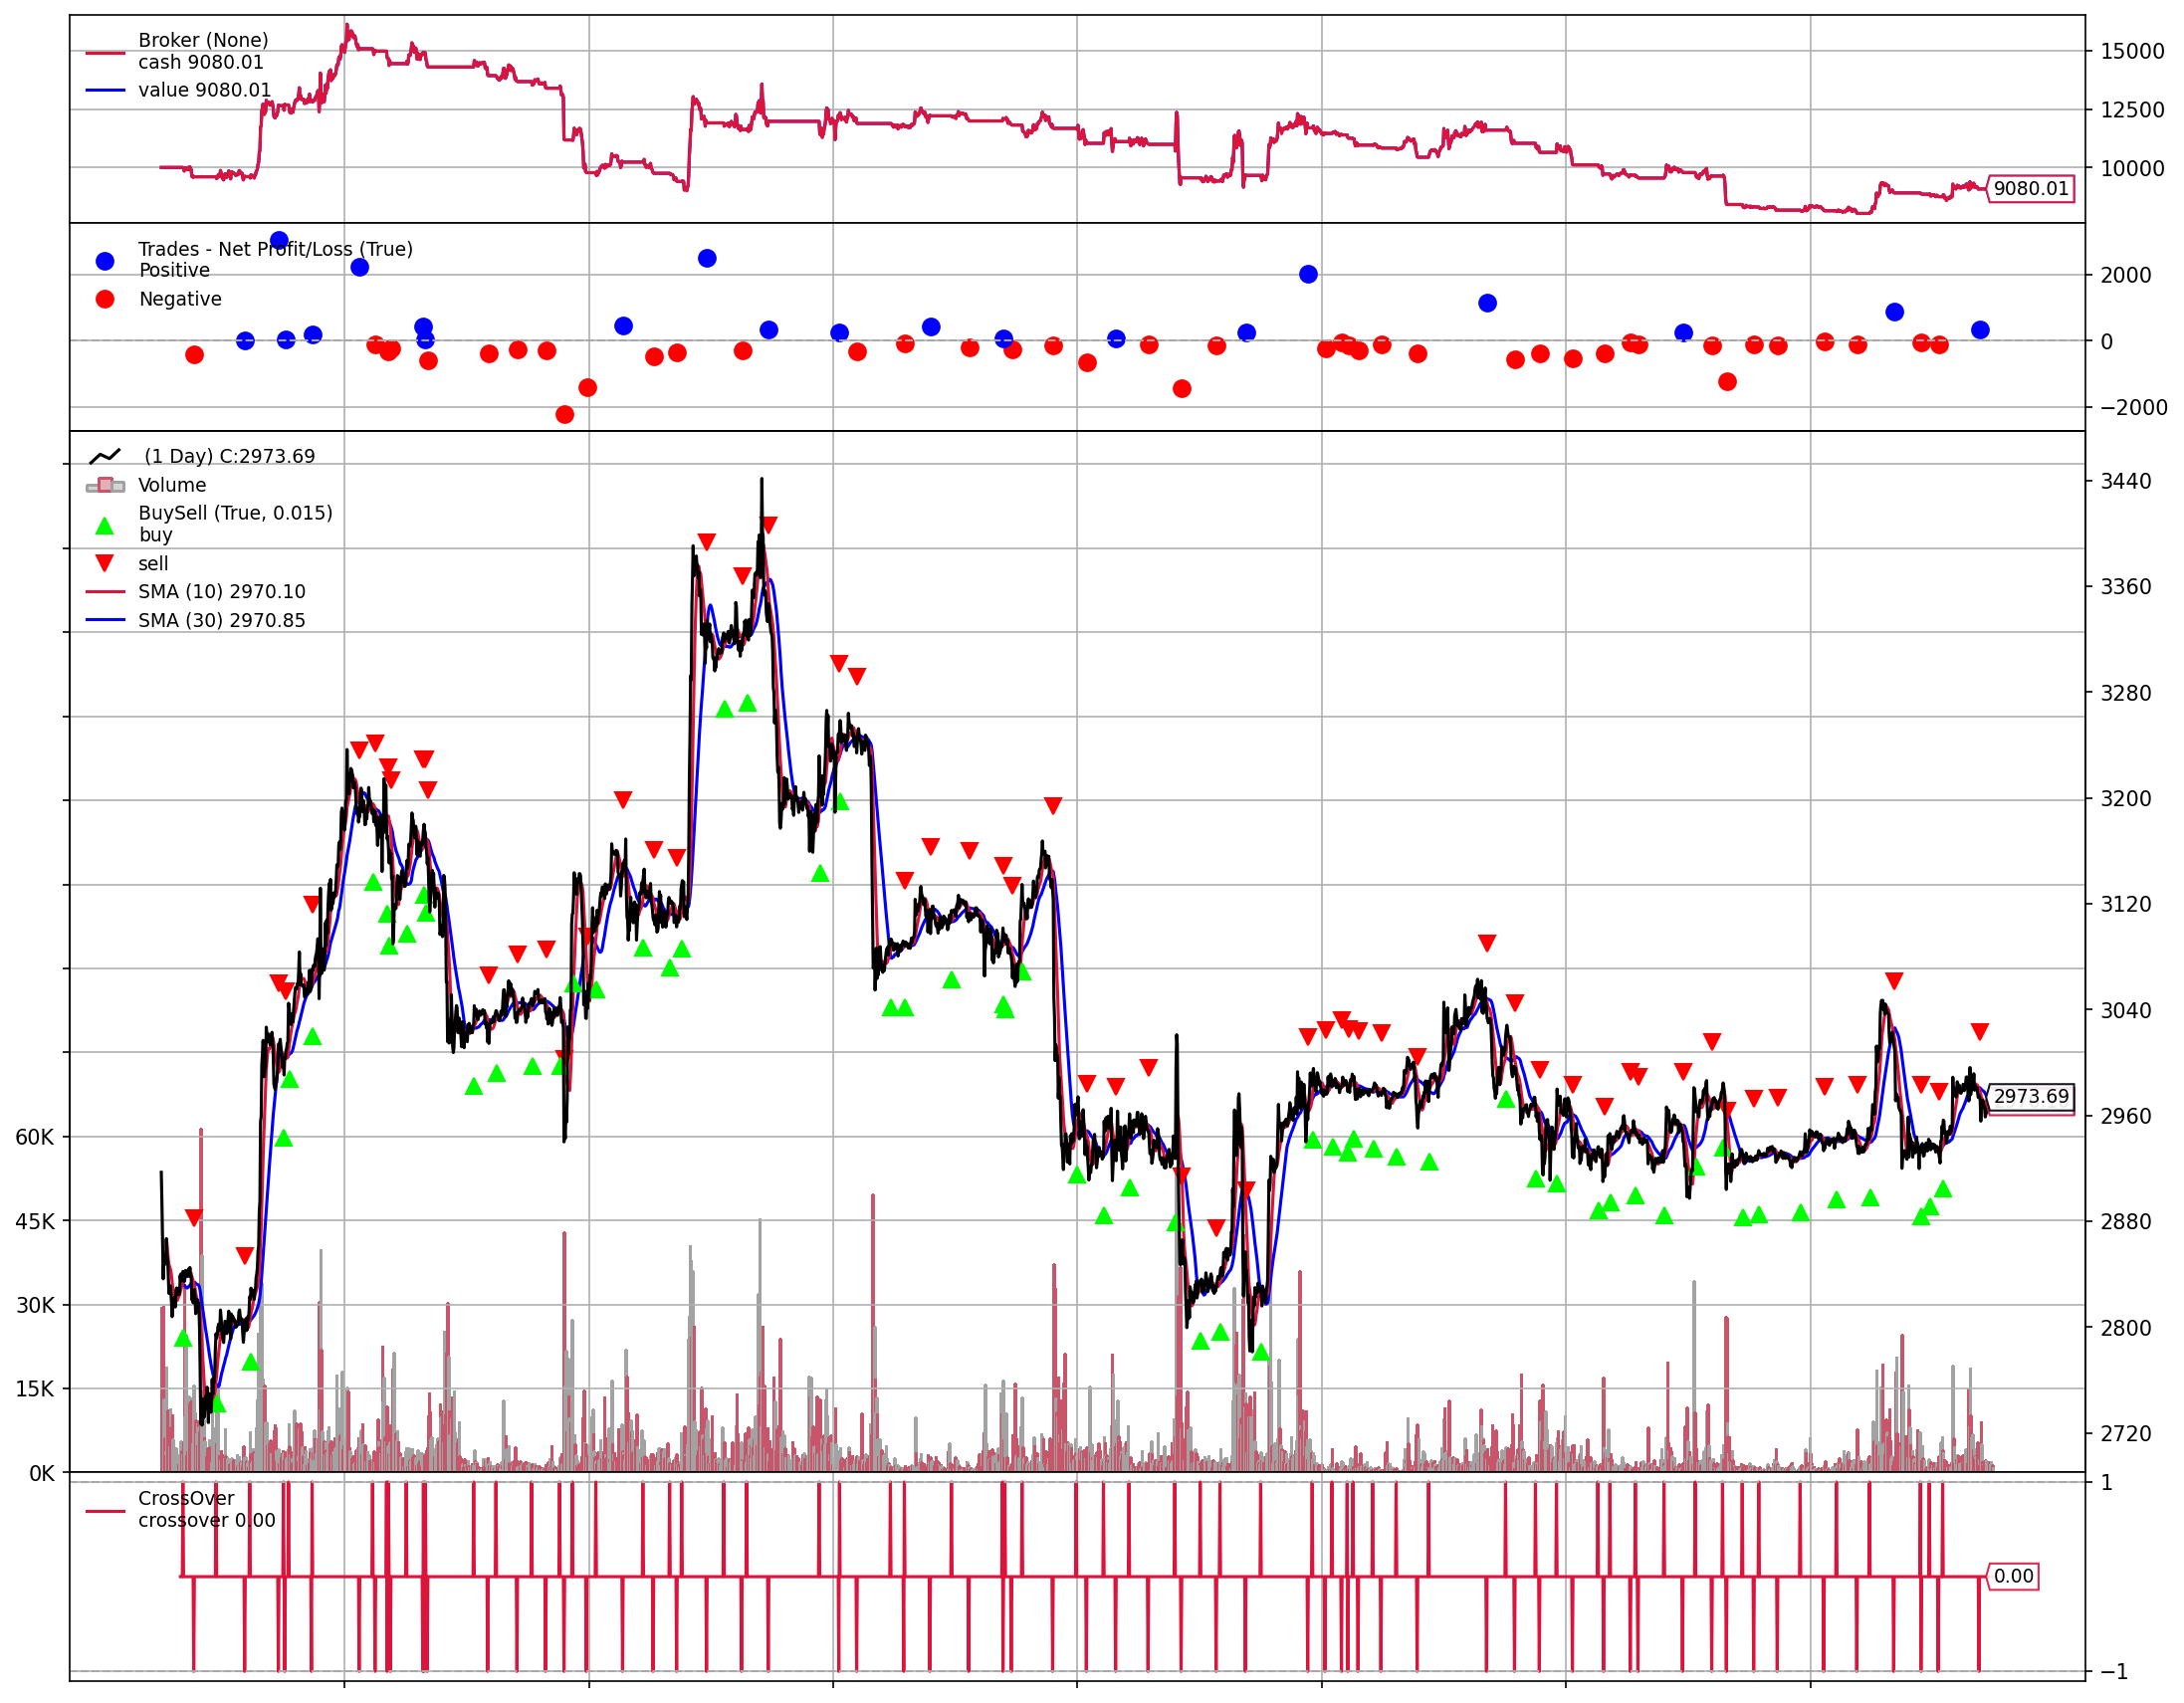

In [14]:
# Backtest configuration - adjust for future tests
BACKTEST_CONFIG = {
    'leverage': 5,
    'initial_cash': 10000.0,
    # Binance Futures commission (USDT-M): https://www.binance.com/en/fee/schedule
    'commission_maker': 0.0002,   # 0.02% - limit orders that add liquidity
    'commission_taker': 0.0005,  # 0.05% - market orders / orders that remove liquidity
    'commission_type': 'taker',  # 'maker' | 'taker' | 'blended' (avg) - use taker for market orders
    'position_pct': 0.95,
    'fast_ma': 10,
    'slow_ma': 30,
}

# Binance Futures commission: maker/taker fee structure
class BinanceFuturesCommInfo(bt.CommInfoBase):
    params = (
        ('stocklike', False),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        ('percabs', True),
        ('commission_maker', 0.0002),
        ('commission_taker', 0.0005),
        ('commission_type', 'taker'),
    )

    def _getcommission(self, size, price, pseudoexec):
        if self.p.commission_type == 'maker':
            rate = self.p.commission_maker
        elif self.p.commission_type == 'taker':
            rate = self.p.commission_taker
        else:
            rate = (self.p.commission_maker + self.p.commission_taker) / 2
        return abs(size) * price * rate

# Simple MA crossover strategy: buy when fast MA crosses above slow MA, sell when below
class MAStrategy(bt.Strategy):
    params = (('fast', 10), ('slow', 30))

    def __init__(self):
        self.fast_ma = bt.indicators.SMA(self.data.close, period=self.params.fast)
        self.slow_ma = bt.indicators.SMA(self.data.close, period=self.params.slow)
        self.crossover = bt.indicators.CrossOver(self.fast_ma, self.slow_ma)

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
        else:
            if self.crossover < 0:
                self.close()

# Prepare data for backtrader: datetime index, OHLCV columns
bt_data = df[['open', 'high', 'low', 'close', 'volume']].copy()
bt_data.index = pd.to_datetime(df['datetime'])
bt_data.index.name = 'datetime'

# Run backtest
cfg = BACKTEST_CONFIG
cerebro = bt.Cerebro()
cerebro.adddata(bt.feeds.PandasData(dataname=bt_data))
cerebro.addstrategy(MAStrategy, fast=cfg['fast_ma'], slow=cfg['slow_ma'])
cerebro.broker.setcash(cfg['initial_cash'])
# Binance Futures commission with maker/taker rates + margin for leverage
comminfo = BinanceFuturesCommInfo(
    commission_maker=cfg['commission_maker'],
    commission_taker=cfg['commission_taker'],
    commission_type=cfg['commission_type'],
    margin=1 / cfg['leverage'],
)
cerebro.broker.addcommissioninfo(comminfo)
# Position size: pct of margin (cash * leverage * pct)
cerebro.addsizer(bt.sizers.PercentSizer, percents=cfg['position_pct'] * cfg['leverage'] * 100)

print('Starting Portfolio Value:', cerebro.broker.getvalue())
cerebro.run()
print('Ending Portfolio Value:', cerebro.broker.getvalue())

import io
from IPython.display import Image, display
plt.rcParams['figure.figsize'] = [15, 12]
figs = cerebro.plot(iplot=False)
for figlist in figs:
    for fig in figlist:
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)
        display(Image(data=buf.getvalue()))
        plt.close(fig)

In [13]:
cerebro.plot()

<IPython.core.display.Javascript object>

[[<Figure size 1500x1200 with 5 Axes>]]